SQLAlchemy & PyCon 2016  
==============
DesertPy 6/22/2016  
---------------------
@ftlphys  
Michael Gilbert

### What is SQLAlchemy?

*"SQLAlchemy is the Python SQL toolkit and Object Relational Mapper that gives application developers the full power and flexibility of SQL.*

*It provides a full suite of well known enterprise-level persistence patterns, designed for efficient and high-performing database access, adapted into a simple and Pythonic domain language." *

In essence, SQLAlchemy gives you the flexibility of both Python & SQL and also helps you change the way you think about both as a means of data storage

####  How do we cross an SQL database with Python?

SQLAlchemy uses an ORM (object relational-mapper) component that maps Python Objects to SQL Tables

* Use SQL syntax, speed, and interoperability
    - SQL is used in many legacy and modern systems
    - Language plugins exist in every major programming language
    - Extremely easy to use and deploy (SQLite being one of the easiest)
* Use Python
    - Pandas
    - Numpy
    - SciPy
    - Thousands upon thousands of useful packages ...

#### The Complementarity Principle...
* In Physics: *"in physics, tenet that a complete knowledge of phenomena on atomic dimensions requires a description of both wave and particle properties"* -[Encyclopedia Britanica](http://www.britannica.com/science/complementarity-principle)
* In Automation: Using a Cognitive Systems Engineering approach to understand the interaction between human and automation to encourage learning and growth. -[Automation Should Be Like Iron Man, Not Ultron](http://queue.acm.org/detail.cfm?id=2841313)
    - Not saying: "Isn't it beautiful? We have no idea how it works"
    - But saying: "Isn't it beautiful how we learn and grow together, sharing control over the system"

#### Let's Look at some Python now!

SQLAlchemy provides many ways to create your objects/tables, we will use the most common and recommended Declarative System [SQLAlchemy Tutorial v1.1](http://docs.sqlalchemy.org/en/latest/orm/tutorial.html).  This link has lots and lots and lots of examples to look at, including some of the standard examples used to demonstrate ORMs.  So let's look at something a little different...

#### Game of Thrones meets Python... 
<img src='1afc5a055a2db233ff88d6131ad3b665.jpg'>

In [21]:
from sqlalchemy import Column, ForeignKey, String, create_engine, DateTime, \
    Integer
from sqlalchemy.orm import Session, relationship, joinedload, backref
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.hybrid import hybrid_property
import datetime
from IPython.display import Image, display

# forms the base from which all of our tables/classes will inherit
Base = declarative_base()

#### To build our GOT world database we need 4 classes/tables
* **Region**: The location within the GOT world (north, south, across the narrow sea, etc.)
* **City**: The cities of the GOT world (Winterfell, King's Landing, etc.)
* **House**: The royal houses (Stark, Lanistar, etc.)
* **Character**: The characters of GOT (Arya, John Snow, etc.)

In [22]:
class Region(Base):
    __tablename__ = 'region' #defines the name of the table within SQL
    idn = Column(Integer, primary_key=True)
    name = Column(String, nullable=False)
    cities = relationship("City", back_populates="region")

    def __repr__(self): # gives a useful reprentation when printed
        return "<Region(name='{}')>".format(self.name)

In [23]:
class City(Base):
    __tablename__ = 'city'
    idn = Column(Integer, primary_key=True)
    name = Column(String, nullable=False)
    ruling_house = relationship("House", back_populates="cities_owned")
    ruling_house_idn = Column(Integer, ForeignKey('house.idn')) 
    region = relationship("Region", back_populates="cities")
    region_idn = Column(Integer, ForeignKey('region.idn')) 

    def __repr__(self):
        return "<City(name='{}')>".format(self.name)

#### Now we will add a little more functionality in the next couple of classes...
* **Hybrid properties/methods**: Used as decorators to provide differing functionality between class and instance (table and entry).  At the class level this would represent an SQL expression and a value at the instance level
* Self-referencing tables can provide a nodal hierarchy for recursive relationships
* Ordinary Python methods can also apply logic for common operations within your framework

In [24]:
class House(Base):
    __tablename__ = 'house'
    idn = Column(Integer, primary_key=True)
    name = Column(String, nullable=False)
    slogan = Column(String)
    cities_owned = relationship("City", back_populates="ruling_house")
    members = relationship("Character", back_populates="house")
    super_house_idn = Column(Integer, ForeignKey('house.idn'))
    sub_houses = relationship('House',
                              backref=backref("super_house",
                                              remote_side=idn),
                              order_by='House.name')

    @hybrid_property
    def return_dead(self):
        return [member for member in self.members if member.life_span]

    @hybrid_property
    def return_living(self):
        return [member for member in self.members
                if member not in self.return_dead]

    @hybrid_property
    def has_dragons(self):
        if any(member.has_dragons for member in self.members):
            return True
        return False

    def wage_war(self, other):
        if self.has_dragons:
            return House.evaluate_losses(self, other)
        elif other.has_dragons:
            return House.evaluate_losses(other, self)
        else:
            return "it's a draw..."

    @staticmethod
    def evaluate_losses(winner, loser):
        for member in loser.members:
            member.deathday = datetime.datetime.now()
            display(Image(filename="output.jpg"))
            print('attribution: http://moviepilot.com/posts/3972495')
        return "{}'s Dragons Prevail against {}!!".format(winner.name,
                                                          loser.name)

    def __repr__(self):
        return "<House(name='{}', slogan='{}')>".format(self.name,
                                                        self.slogan)

In [25]:
class Character(Base):
    __tablename__ = 'character'
    idn = Column(Integer, primary_key=True)
    name = Column(String, nullable=False)
    birthday = Column(DateTime, nullable=False)
    deathday = Column(DateTime)
    house = relationship("House", back_populates="members")
    house_idn = Column(Integer, ForeignKey('house.idn'))

    @hybrid_property
    def life_span(self):
        try:
            return self.deathday - self.birthday
        except TypeError:
            return None

    @hybrid_property
    def has_dragons(self):
        if self.name == 'daenerys':
            return True
        return False

    def __repr__(self):
        return "<Character(name='{}', house='{}')>".format(
                                                        self.name,
                                                        self.house.name)

#### We can visualize these class structures in two ways, a class diagram, and an sqlalchemy diagram

<img src="classdiagram.png">

<img src="sqldiagram.png">

#### Now let's create a session and build our GOT world!

In [26]:
engine = create_engine('sqlite:///test.db',
                       echo=True)  # echo will show SQL commands
Base.metadata.create_all(engine)
session = Session(
    engine)  # autoflush=False to control database flushing manually

2016-06-23 20:46:59,094 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2016-06-23 20:46:59,095 INFO sqlalchemy.engine.base.Engine ()
2016-06-23 20:46:59,097 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2016-06-23 20:46:59,098 INFO sqlalchemy.engine.base.Engine ()
2016-06-23 20:46:59,100 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("house")
2016-06-23 20:46:59,100 INFO sqlalchemy.engine.base.Engine ()
2016-06-23 20:46:59,101 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("region")
2016-06-23 20:46:59,102 INFO sqlalchemy.engine.base.Engine ()
2016-06-23 20:46:59,102 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("city")
2016-06-23 20:46:59,103 INFO sqlalchemy.engine.base.Engine ()
2016-06-23 20:46:59,104 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("character")
2016-06-23 20:46:59,104 INFO sqlalchemy.engine.base.Engine ()
2016-06-23 20:46:59,105 INFO sqlalchemy.en

In [27]:
# Create regions
north = Region(name='north')
south = Region(name='south')
narrow_sea = Region(name='narrow sea')
session.add(north)
session.add(south)
session.add(narrow_sea)
session.commit()

#query the database to see that our regions are there
regions = session.query(Region).all()
print(regions)

2016-06-23 20:46:59,224 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2016-06-23 20:46:59,226 INFO sqlalchemy.engine.base.Engine INSERT INTO region (name) VALUES (?)
2016-06-23 20:46:59,227 INFO sqlalchemy.engine.base.Engine ('north',)
2016-06-23 20:46:59,229 INFO sqlalchemy.engine.base.Engine INSERT INTO region (name) VALUES (?)
2016-06-23 20:46:59,229 INFO sqlalchemy.engine.base.Engine ('south',)
2016-06-23 20:46:59,230 INFO sqlalchemy.engine.base.Engine INSERT INTO region (name) VALUES (?)
2016-06-23 20:46:59,231 INFO sqlalchemy.engine.base.Engine ('narrow sea',)
2016-06-23 20:46:59,233 INFO sqlalchemy.engine.base.Engine COMMIT
2016-06-23 20:46:59,260 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2016-06-23 20:46:59,262 INFO sqlalchemy.engine.base.Engine SELECT region.idn AS region_idn, region.name AS region_name 
FROM region
2016-06-23 20:46:59,264 INFO sqlalchemy.engine.base.Engine ()
[<Region(name='north')>, <Region(name='south')>, <Region(name='narrow sea')>]


In [28]:
# Create cities and link them to regions
winterfell = City(name='winterfell', region=north)
kings_landing = City(name='kings landing', region=south)
meereen = City(name='meereen', region=narrow_sea)
session.commit()

2016-06-23 20:46:59,275 INFO sqlalchemy.engine.base.Engine INSERT INTO city (name, ruling_house_idn, region_idn) VALUES (?, ?, ?)
2016-06-23 20:46:59,276 INFO sqlalchemy.engine.base.Engine ('winterfell', None, 1)
2016-06-23 20:46:59,277 INFO sqlalchemy.engine.base.Engine INSERT INTO city (name, ruling_house_idn, region_idn) VALUES (?, ?, ?)
2016-06-23 20:46:59,277 INFO sqlalchemy.engine.base.Engine ('kings landing', None, 2)
2016-06-23 20:46:59,278 INFO sqlalchemy.engine.base.Engine INSERT INTO city (name, ruling_house_idn, region_idn) VALUES (?, ?, ?)
2016-06-23 20:46:59,279 INFO sqlalchemy.engine.base.Engine ('meereen', None, 3)
2016-06-23 20:46:59,280 INFO sqlalchemy.engine.base.Engine COMMIT


In [29]:
regions = session.query(Region).options(joinedload('cities')).all()
for r in regions:
    print(r.name, r.cities)

2016-06-23 20:46:59,307 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2016-06-23 20:46:59,311 INFO sqlalchemy.engine.base.Engine SELECT region.idn AS region_idn, region.name AS region_name, city_1.idn AS city_1_idn, city_1.name AS city_1_name, city_1.ruling_house_idn AS city_1_ruling_house_idn, city_1.region_idn AS city_1_region_idn 
FROM region LEFT OUTER JOIN city AS city_1 ON region.idn = city_1.region_idn
2016-06-23 20:46:59,313 INFO sqlalchemy.engine.base.Engine ()
north [<City(name='winterfell')>]
south [<City(name='kings landing')>]
narrow sea [<City(name='meereen')>]


In [30]:
# Create houses
lannister = House(name='lannister', slogan='a lanistar always repays his debts')
targaryen = House(name='targaryen', slogan='fire and blood')
stark = House(name='stark', slogan='winter is coming')
freys = House(name='freys')

# Assign the cities
lannister.cities_owned.append(kings_landing)
targaryen.cities_owned.append(meereen)
stark.cities_owned.append(winterfell)
lannister.sub_houses.append(freys)
session.commit()

2016-06-23 20:46:59,335 INFO sqlalchemy.engine.base.Engine INSERT INTO house (name, slogan, super_house_idn) VALUES (?, ?, ?)
2016-06-23 20:46:59,336 INFO sqlalchemy.engine.base.Engine ('lannister', 'a lanistar always repays his debts', None)
2016-06-23 20:46:59,338 INFO sqlalchemy.engine.base.Engine INSERT INTO house (name, slogan, super_house_idn) VALUES (?, ?, ?)
2016-06-23 20:46:59,339 INFO sqlalchemy.engine.base.Engine ('targaryen', 'fire and blood', None)
2016-06-23 20:46:59,340 INFO sqlalchemy.engine.base.Engine INSERT INTO house (name, slogan, super_house_idn) VALUES (?, ?, ?)
2016-06-23 20:46:59,341 INFO sqlalchemy.engine.base.Engine ('stark', 'winter is coming', None)
2016-06-23 20:46:59,348 INFO sqlalchemy.engine.base.Engine INSERT INTO house (name, slogan, super_house_idn) VALUES (?, ?, ?)
2016-06-23 20:46:59,349 INFO sqlalchemy.engine.base.Engine ('freys', None, 1)
2016-06-23 20:46:59,353 INFO sqlalchemy.engine.base.Engine UPDATE city SET ruling_house_idn=? WHERE city.idn 

In [31]:
houses = session.query(House).options(joinedload('cities_owned'),
                                      joinedload('sub_houses'))
for h in houses:
    print(h.name, h.slogan, h.cities_owned)
    print(h.super_house, h.sub_houses, '\n')

2016-06-23 20:46:59,408 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2016-06-23 20:46:59,413 INFO sqlalchemy.engine.base.Engine SELECT house.idn AS house_idn, house.name AS house_name, house.slogan AS house_slogan, house.super_house_idn AS house_super_house_idn, city_1.idn AS city_1_idn, city_1.name AS city_1_name, city_1.ruling_house_idn AS city_1_ruling_house_idn, city_1.region_idn AS city_1_region_idn, house_1.idn AS house_1_idn, house_1.name AS house_1_name, house_1.slogan AS house_1_slogan, house_1.super_house_idn AS house_1_super_house_idn 
FROM house LEFT OUTER JOIN city AS city_1 ON house.idn = city_1.ruling_house_idn LEFT OUTER JOIN house AS house_1 ON house.idn = house_1.super_house_idn ORDER BY house_1.name
2016-06-23 20:46:59,415 INFO sqlalchemy.engine.base.Engine ()
targaryen fire and blood [<City(name='meereen')>]
None [] 

stark winter is coming [<City(name='winterfell')>]
None [] 

freys None []
<House(name='lannister', slogan='a lanistar always repays his debts'

In [32]:
# Create characters
daenerys = Character(name='daenerys',
                     house=targaryen,
                     birthday=datetime.datetime(1990, 1, 1))
cersei = Character(name='cersei',
                   house=lannister,
                   birthday=datetime.datetime(1985, 1, 1))
arya = Character(name='arya',
                 house=stark,
                 birthday=datetime.datetime(2001, 1, 1))
session.commit()

2016-06-23 20:46:59,433 INFO sqlalchemy.engine.base.Engine INSERT INTO character (name, birthday, deathday, house_idn) VALUES (?, ?, ?, ?)
2016-06-23 20:46:59,434 INFO sqlalchemy.engine.base.Engine ('daenerys', '1990-01-01 00:00:00.000000', None, 2)
2016-06-23 20:46:59,436 INFO sqlalchemy.engine.base.Engine INSERT INTO character (name, birthday, deathday, house_idn) VALUES (?, ?, ?, ?)
2016-06-23 20:46:59,437 INFO sqlalchemy.engine.base.Engine ('cersei', '1985-01-01 00:00:00.000000', None, 1)
2016-06-23 20:46:59,439 INFO sqlalchemy.engine.base.Engine INSERT INTO character (name, birthday, deathday, house_idn) VALUES (?, ?, ?, ?)
2016-06-23 20:46:59,440 INFO sqlalchemy.engine.base.Engine ('arya', '2001-01-01 00:00:00.000000', None, 3)
2016-06-23 20:46:59,443 INFO sqlalchemy.engine.base.Engine COMMIT


In [33]:
chrs = session.query(Character).options(joinedload('house')).all()
for c in chrs:
    print(c.name, c.house)
    print(c.life_span)

2016-06-23 20:46:59,467 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2016-06-23 20:46:59,471 INFO sqlalchemy.engine.base.Engine SELECT character.idn AS character_idn, character.name AS character_name, character.birthday AS character_birthday, character.deathday AS character_deathday, character.house_idn AS character_house_idn, house_1.idn AS house_1_idn, house_1.name AS house_1_name, house_1.slogan AS house_1_slogan, house_1.super_house_idn AS house_1_super_house_idn 
FROM character LEFT OUTER JOIN house AS house_1 ON house_1.idn = character.house_idn
2016-06-23 20:46:59,472 INFO sqlalchemy.engine.base.Engine ()
daenerys <House(name='targaryen', slogan='fire and blood')>
None
cersei <House(name='lannister', slogan='a lanistar always repays his debts')>
None
arya <House(name='stark', slogan='winter is coming')>
None


#### Our world is set, so now let's have an event...
* The "wage_war" method on the house provides a means of altering our database
    - This method is not part of the database schema, but will alter data held in the database if we fire the event and commit to our session
* We will then see how the hybrid methods can be used to hold SQL expressions and filter our queries

2016-06-23 20:46:59,488 INFO sqlalchemy.engine.base.Engine SELECT character.idn AS character_idn, character.name AS character_name, character.birthday AS character_birthday, character.deathday AS character_deathday, character.house_idn AS character_house_idn 
FROM character 
WHERE ? = character.house_idn
2016-06-23 20:46:59,490 INFO sqlalchemy.engine.base.Engine (1,)
2016-06-23 20:46:59,492 INFO sqlalchemy.engine.base.Engine SELECT character.idn AS character_idn, character.name AS character_name, character.birthday AS character_birthday, character.deathday AS character_deathday, character.house_idn AS character_house_idn 
FROM character 
WHERE ? = character.house_idn
2016-06-23 20:46:59,494 INFO sqlalchemy.engine.base.Engine (2,)


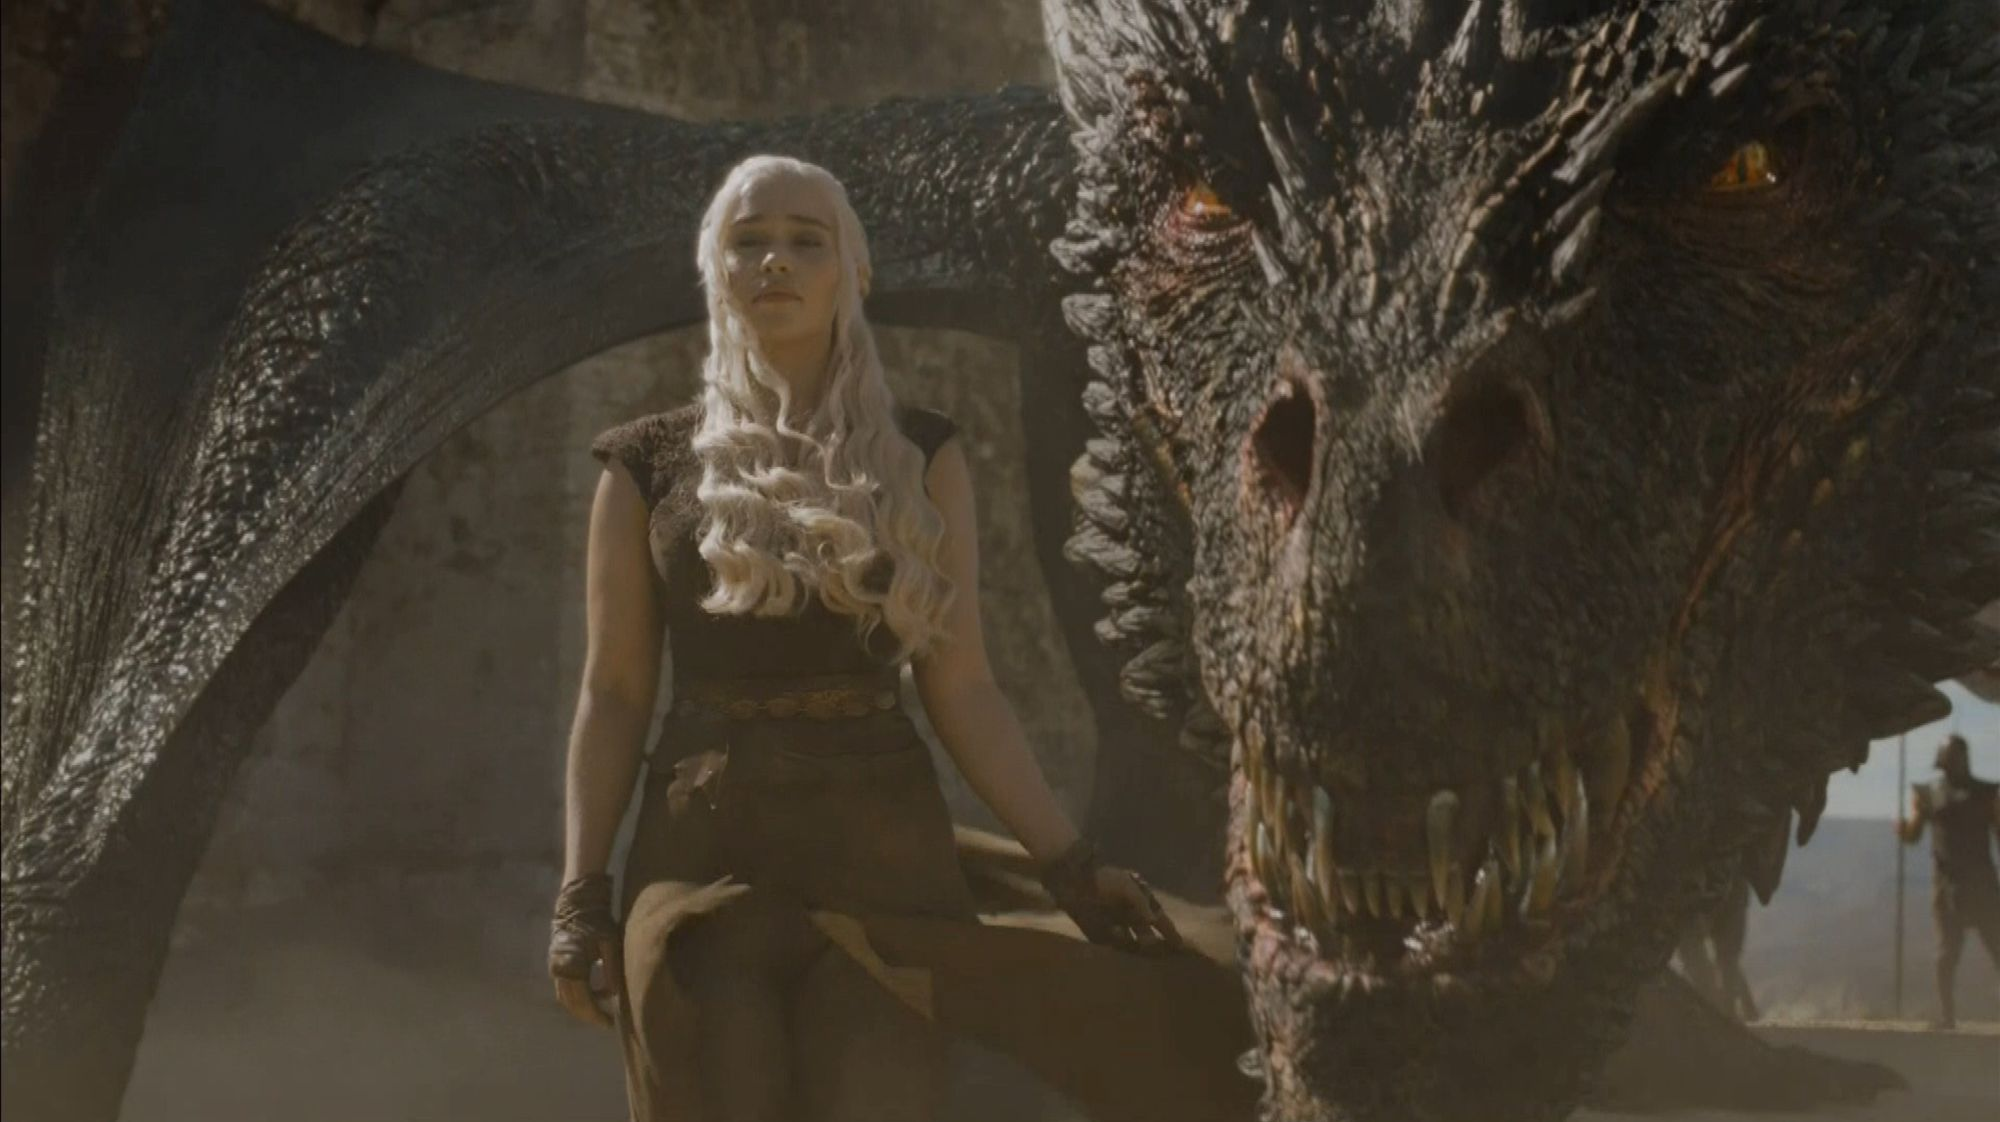

attribution: http://moviepilot.com/posts/3972495
targaryen's Dragons Prevail against lannister!!
2016-06-23 20:46:59,506 INFO sqlalchemy.engine.base.Engine UPDATE character SET deathday=? WHERE character.idn = ?
2016-06-23 20:46:59,507 INFO sqlalchemy.engine.base.Engine ('2016-06-23 20:46:59.496650', 2)
2016-06-23 20:46:59,510 INFO sqlalchemy.engine.base.Engine COMMIT


In [34]:
print(lannister.wage_war(targaryen))
session.commit()

In [35]:
chrs = session.query(Character).options(
                     joinedload('house')).filter(
                     Character.life_span != None).all()
# checking on house lanistar
for c in chrs:
        print(c, c.house, c.deathday)

2016-06-23 20:46:59,536 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2016-06-23 20:46:59,540 INFO sqlalchemy.engine.base.Engine SELECT character.idn AS character_idn, character.name AS character_name, character.birthday AS character_birthday, character.deathday AS character_deathday, character.house_idn AS character_house_idn, house_1.idn AS house_1_idn, house_1.name AS house_1_name, house_1.slogan AS house_1_slogan, house_1.super_house_idn AS house_1_super_house_idn 
FROM character LEFT OUTER JOIN house AS house_1 ON house_1.idn = character.house_idn 
WHERE character.deathday - character.birthday IS NOT NULL
2016-06-23 20:46:59,541 INFO sqlalchemy.engine.base.Engine ()
<Character(name='cersei', house='lannister')> <House(name='lannister', slogan='a lanistar always repays his debts')> 2016-06-23 20:46:59.496650


#### A quick note and a very useful function  
If you are persisting your database (not holding it in memory like we have done here) and you need to build a relationship to some entry you made in a previous session (or you think you may have at least), you can use the following very convenient function:
```python
def get_or_create(model, session, **kwargs):
    entry = session.query(model).filter_by(**kwargs).first()
    if entry is None:
        entry=model(**kwargs)
    return entry
```

####  So we have to ask, can we use Pandas???

YES!!

In [36]:
import pandas as pd
pd.read_sql('house', engine)

2016-06-23 20:46:59,551 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("house")
2016-06-23 20:46:59,552 INFO sqlalchemy.engine.base.Engine ()
2016-06-23 20:46:59,555 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2016-06-23 20:46:59,556 INFO sqlalchemy.engine.base.Engine ()
2016-06-23 20:46:59,560 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("house")
2016-06-23 20:46:59,561 INFO sqlalchemy.engine.base.Engine ()
2016-06-23 20:46:59,563 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("house")
2016-06-23 20:46:59,564 INFO sqlalchemy.engine.base.Engine ()
2016-06-23 20:46:59,569 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'house' AND type = 'table'
2016-06-23 20:46:59,570 INFO sqlalchemy.engine.base.Engine ()
2016-06-23 20:46:59,571 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("house")
2016-06-23 20:46:59,573 IN

,idn,name,slogan,super_house_idn
0,1,lannister,a lanistar always repays his debts,NaN
1,2,targaryen,fire and blood,NaN
2,3,stark,winter is coming,NaN
3,4,freys,None,1.0


#### Building an SQLAlchemy ORM from an existing database  

The database created above has been persisted to 'test.db' to have an existing database from which to create an ORM.  

* You can autogenerate the Python Code for a declarative based ORM using [**sqlacodegen**](https://pypi.python.org/pypi/sqlacodegen/), just *pip install sqlacodegen*
* You can implicity build the ORM using [**Automap**](http://docs.sqlalchemy.org/en/latest/orm/extensions/automap.html) found in SQLAlchemy.  While you get a fully functioning ORM, it doesn't explicity render the Python code.

In [37]:
!sqlacodegen sqlite:///test.db

# coding: utf-8
from sqlalchemy import Column, DateTime, ForeignKey, Integer, String
from sqlalchemy.orm import relationship
from sqlalchemy.ext.declarative import declarative_base


Base = declarative_base()
metadata = Base.metadata


class Character(Base):
    __tablename__ = 'character'

    idn = Column(Integer, primary_key=True)
    name = Column(String, nullable=False)
    birthday = Column(DateTime, nullable=False)
    deathday = Column(DateTime)
    house_idn = Column(ForeignKey('house.idn'))

    house = relationship('House')


class City(Base):
    __tablename__ = 'city'

    idn = Column(Integer, primary_key=True)
    name = Column(String, nullable=False)
    ruling_house_idn = Column(ForeignKey('house.idn'))
    region_idn = Column(ForeignKey('region.idn'))

    region = relationship('Region')
    house = relationship('House')


class House(Base):
    __tablename__ = 'house'

    idn = Column(Integer, primary_key=True)
    name = Column(String, nullable=False)
    slogan = 

Notice that while the above Python code lacks the methods and some of the more robost relationship syntax, it is equivalent as far as the SQL code can express.  
* The relationships will evaluate to sql expressions around the foreign keys, so feel free to make them more robust by back populating as was done in the original Python code.  You will not change the database schema in any way unless you change the foreign keys.
* The methods also evaluate to sql expressions, so if you want them, you will need to create them on this "barebones" python class structure.

In [73]:
from sqlalchemy.ext.automap import automap_base

Base = automap_base()
engine = create_engine("sqlite:///test.db")
Base.prepare(engine, reflect=True)
session = Session(engine)
# the table names are retained as the class names in the mapping
House = Base.classes.house

session.query(House).all()

In [74]:
for h in houses:
    print('name: ', h.name)
    try:
        print('  super_house:', h.house.name)
    except AttributeError:
        print('  super_house:', h.house)
    print('  members:', [m.name for m in h.character_collection])
    print('  cities_owned:', [c.name for c in h.city_collection])
    print('  sub_houses:', [s.name for s in h.house_collection])

name:  lannister
  super_house: None
  members: ['cersei']
  cities_owned: ['kings landing']
  sub_houses: ['freys']
name:  targaryen
  super_house: None
  members: ['daenerys']
  cities_owned: ['meereen']
  sub_houses: []
name:  stark
  super_house: None
  members: ['arya']
  cities_owned: ['winterfell']
  sub_houses: []
name:  freys
  super_house: lannister
  members: []
  cities_owned: []
  sub_houses: []


The above automap is very powerful by default.  Unlike sqlacodegen, you don't get the Python code, but you do retain full bi-directional relationships.  The naming schema is explained the documentation and can be adjusted to your liking upon automapping.  

With these above two options, you can do quite a bit with existing databases!

For a nice article on how data scientists can benefit from ORMs, check out the link below:  

http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/12/datasci-sqlalchemy/

### PyCon 2016 Highlights!

Pycon was held in Portland Oregon this year and will be in the same place next year! [PyCon 2016](https://us.pycon.org/2016/)
* 2 days of Tutorials
* 3 days of Talks (the main conference)
* 4 days of Sprints (work on open source projects and learn lots!)

#### Diversity, Education, Data Science, & The Future of the Web

#### Some outstanding Keynotes
* [Lorena Barba](https://www.youtube.com/watch?v=ckW1xuGVpug)
    - Language/Action perspective, Computer Education, Computer Literacy
* [K Lars Lohn](https://www.youtube.com/watch?v=bSfe5M_zG2s)
    - Education, Complexity, Life & Choices
* [Guido van Rossum](https://www.youtube.com/watch?v=YgtL4S7Hrwo)
    - Language Update, Computer Science education, a little history

#### Home Automation and Integration for Everyone!
* [Home Assisant](https://home-assistant.io/) is a home automation system written in Python 3 with support for hundreds of smart home devices.  
* The control is entirely yours, not rendered via the cloud
* Supports automation "scripts" that can tie isolated devices together into a seemless ecosystem  

Pycon 2016 Talk [Awaken your home: Python and the Internet of Things](https://www.youtube.com/watch?v=Cfasc9EgbMU)

#### The Infamous GIL!!
* Can we remove the GIL from Python??
    - Yes, but everything slows down!
    - Work is progressing to deal with the "low hanging watermelons"
* Guido has mandated that the removal of the GIL must not compromise single threaded performance  
* Maybe Python 3.7??

Pycon 2016 Talk [Removing Python's GIL: The Gilectomy](https://www.youtube.com/watch?v=P3AyI_u66Bw)

#### Jupyter Notebooks as a first class business application
* At Yelp, they use jupyter notebooks to produce recuring and adhoc queries in multiple departments
* Compiling jupyter notebooks into html for persistence
* Button to toggle code
* Plotting in matplotlib, but [bokeh](http://bokeh.pydata.org/en/latest/) may be an even better option if downloading to html.

Pycon 2016 Talk [IPython Notebook in Data Intensive Communities: Accelerating the process of Discovery](https://www.youtube.com/watch?v=5gy6svL1DuU)

Find all of the talks and tutorials at the link below:  

https://www.youtube.com/channel/UCwTD5zJbsQGJN75MwbykYNw/feed

Questions??